In [ ]:
##############################################################################
###                   PIA - SHAMIR A. RODRIGUEZ OJEDA 1423061               ##
###                     Maestria en Ciencia de Datos                        ##
###                            12/04/2024                                   ##
###                                                                         ##
##############################################################################

# Instalación Librerias

In [ ]:
!pip install --q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install --q pyod       # Detección de atipicos +30 algoritmos
!pip install --q catboost   # Catboost
!pip install --q imblearn   # Balanceo de clases

     - 17.8 MB 26.6 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from pathlib import Path

In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

<ipython-input-3-c03a24be5f20>:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from pyod.models.lof import LOF
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from imblearn.over_sampling import ADASYN
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool


import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters

import warnings
warnings.filterwarnings("ignore")

In [ ]:
SEED=111

#Funciones

In [ ]:
def grafica_correla(df, paleta="Greens"):
  import seaborn as sns
  import matplotlib.pyplot as plt
  from string import ascii_letters
  fig, ax = plt.subplots(figsize=(6, 6))
  mask = np.zeros_like(df.corr())
  mask[np.triu_indices_from(mask)] = 1
  sns.heatmap(df.corr(), mask= mask, cmap=paleta)

In [ ]:
def refusion_dimension(df, umbral=0.95):
  corr_df = df.corr().abs()
  mask = np.triu(np.ones_like(corr_df, dtype=bool))
  correlacion = df.corr()
  tri_df = correlacion.mask(mask)
  to_drop = [c for c in tri_df.columns if any(tri_df[c] > umbral)]
  return to_drop

# Contexto

*Datos de entrada*:
Un archivo TRAIN en formato tabular con 27 atributos/variables independientes, 7 clases/ variables dependientes y 1455 observaciones.
Las clases:
Pastry

*  Z_Scratch
*  K_Scatch
*  Stains
*  Dirtiness
*  Bumps
*  Other_Faults

Son defectos que se encuentran en los planchones de acero.

Un archivo TEST en formato tabular con  27 atributos/variables y 485 observaciones sobre las que se hará la clasificación de las variables faltantes.


**Entregable:**
*   El archivo en formato tabular, con las clases concatenadas al final del archivo, siguiendo el formato del archivo TRAIN.
*  El código Python con el que se obtuvo la clasificación, debidamente comentado.
*  Adicionalmente, se pueden entregar visualizaciones del set de datos y de la solución propuesta, así como su justificación.



#Importación de datos

In [ ]:
link_lectura='/content/drive/MyDrive/Shamir/Datos_Masivos/'
name_file= 'Faults.train'
name_report='REPORT.html'
name_file_test='Faults.test'
name_file_exist= 'salida.csv'
name_user = 'Christian'

train=pd.read_csv(link_lectura+name_file, sep='\t',index_col=0)
print("La dimension del DataFrame de train es {}".format(train.shape))

La dimension del DataFrame de train es (1455, 34)


Para poder realizar la entraga siguiendo el formato del archivo TRAIN, se requiere saber las variables iniciales dadas para el caso de uso.

In [ ]:
etiquetas= train.iloc[:,:-7].columns
len(etiquetas)

27

Se creo un reporte previo para la exploración de los datos EDA.
El archivo html tiene varios analisis sobre los datos iniciales.

In [ ]:
profile = ProfileReport(train, title='Pandas Profiling Report', html={'style':{'full_width':False}})

In [ ]:
profile.to_notebook_iframe()

In [ ]:
profile.to_file(output_file=link_lectura+name_report)

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Para verificar cuantos nulos tiene el dataframe 

In [ ]:
train.isnull().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

In [ ]:
train.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,1455.000000,1455.000000,1.455000e+03,1.455000e+03,1455.000000,1455.000000,1455.000000,1.455000e+03,1455.000000,1455.000000,...,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000
mean,570.035052,616.305155,1.676894e+06,1.676950e+06,1908.098282,113.644674,85.914089,2.069553e+05,84.661168,130.021993,...,0.087881,-0.130914,0.582273,0.081100,0.099656,0.202062,0.037113,0.028866,0.207560,0.343643
std,516.641171,493.543539,1.826262e+06,1.826278e+06,5540.549250,331.232990,487.996747,5.333202e+05,32.375866,18.461963,...,0.498667,0.151795,0.340529,0.273082,0.299644,0.401676,0.189105,0.167487,0.405699,0.475087
min,0.000000,4.000000,6.712000e+03,6.724000e+03,2.000000,2.000000,1.000000,2.500000e+02,0.000000,37.000000,...,-0.973900,-0.998900,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.000000,194.000000,5.026940e+05,5.028045e+05,82.500000,15.000000,13.000000,9.374000e+03,63.000000,124.000000,...,-0.295200,-0.195000,0.243200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435.000000,466.000000,1.223690e+06,1.223696e+06,172.000000,26.000000,25.000000,1.898600e+04,90.000000,127.000000,...,0.098800,-0.132600,0.496300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1046.500000,1070.000000,2.183653e+06,2.183658e+06,794.000000,82.500000,83.000000,8.165950e+04,106.000000,140.000000,...,0.506650,-0.066100,0.999800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,247.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
1309,1343,1351,46714,46725,56,11,11,5729,90,117,...,0.2727,-0.2007,0.1934,0,0,0,0,0,0,1
1132,354,370,409908,409918,116,19,10,12174,82,126,...,-0.3750,-0.1801,0.2792,0,0,0,0,0,1,0
1230,1056,1077,4364066,4364076,106,35,22,10747,89,116,...,-0.5238,-0.2079,0.3509,0,0,0,0,0,1,0
783,816,822,899659,899665,18,8,6,2384,127,141,...,0.0000,0.0347,0.1449,0,0,0,1,0,0,0
1762,78,94,1523381,1523431,463,69,54,60518,118,141,...,0.6800,0.0212,0.9650,0,0,0,0,0,0,1


Al parecer las clases estan divididas en multiples columnas, se esperaba que existiera una sola columna con las clases objetivo.
La información hace suponer que se hizo una estrategia de encoding sobre las clases, para verificar está postura se hará algunas comprobaciones.
Si el proceso es resultado de un **One-hot encoding**, la suma de elementos presentes sobre un dataframe filtrado a solo clases será **1**, en caso contrario podriamos estar teniendo un problema multietiqueta. Es decir que un mismo planchon tenga simultanemanente dos o más defectos.

La variable mask tiene los ultimos 7 elementos de los nombres del dataframe (DF), las cuales representan las clases objetivo.
Se procede a realizar la extracción de solas estas variables del DF train y se procede a realizar la suma horizontal. Pareciera que la suma para cada fila es 1. Puse un proceso adicional para garantizarlo (linea 5), como la salida es igual a TRUE por consiguiente este DF viene de un proceso de one-hot encoding.  

In [ ]:
mask= train.columns[-7:]
classes= train[mask]
classes.sum(axis=1)

classes.sum(axis=1).sum()==train.shape[0]

True

Se va a proceder a eliminar las clases individuales del DF train para despues concadenar la columna **target**

In [ ]:
train.drop(mask, axis=1, inplace=True)
train

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
1309,1343,1351,46714,46725,56,11,11,5729,90,117,...,0.0059,0.7273,1.0000,1.0,1.7482,0.9031,1.0414,0.2727,-0.2007,0.1934
1132,354,370,409908,409918,116,19,10,12174,82,126,...,0.0118,0.8421,1.0000,0.0,2.0645,1.2041,1.0000,-0.3750,-0.1801,0.2792
1230,1056,1077,4364066,4364076,106,35,22,10747,89,116,...,0.0154,0.6000,0.4545,0.0,2.0253,1.3222,1.0000,-0.5238,-0.2079,0.3509
783,816,822,899659,899665,18,8,6,2384,127,141,...,0.0044,0.7500,1.0000,0.5,1.2553,0.7782,0.7782,0.0000,0.0347,0.1449
1762,78,94,1523381,1523431,463,69,54,60518,118,141,...,0.0118,0.2319,0.9259,1.0,2.6656,1.2041,1.6990,0.6800,0.0212,0.9650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,677,686,3379334,3379344,69,12,10,7774,95,132,...,0.0054,0.7500,1.0000,1.0,1.8389,0.9542,1.0000,0.1000,-0.1198,0.1954
1702,114,134,115356,115418,532,75,73,54451,94,111,...,0.0144,0.2667,0.8493,1.0,2.7259,1.3010,1.7924,0.6774,-0.2004,0.9981
194,109,121,560425,560445,124,18,20,13549,97,124,...,0.0089,0.6667,1.0000,1.0,2.0934,1.0792,1.3010,0.4000,-0.1464,0.3977
1335,373,386,1058240,1058279,308,29,39,37264,113,132,...,0.0095,0.4483,1.0000,1.0,2.4885,1.1139,1.5911,0.6667,-0.0548,0.7966


# Reversa de One-Hot Encoding
Se crea la columna target que toma el one-hot encoding y se hace el proceso de reversa.

In [ ]:
train['target'] = classes.apply(lambda x: x.idxmax(), axis = 1)
train

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,target
1309,1343,1351,46714,46725,56,11,11,5729,90,117,...,0.7273,1.0000,1.0,1.7482,0.9031,1.0414,0.2727,-0.2007,0.1934,Other_Faults
1132,354,370,409908,409918,116,19,10,12174,82,126,...,0.8421,1.0000,0.0,2.0645,1.2041,1.0000,-0.3750,-0.1801,0.2792,Bumps
1230,1056,1077,4364066,4364076,106,35,22,10747,89,116,...,0.6000,0.4545,0.0,2.0253,1.3222,1.0000,-0.5238,-0.2079,0.3509,Bumps
783,816,822,899659,899665,18,8,6,2384,127,141,...,0.7500,1.0000,0.5,1.2553,0.7782,0.7782,0.0000,0.0347,0.1449,Stains
1762,78,94,1523381,1523431,463,69,54,60518,118,141,...,0.2319,0.9259,1.0,2.6656,1.2041,1.6990,0.6800,0.0212,0.9650,Other_Faults
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,677,686,3379334,3379344,69,12,10,7774,95,132,...,0.7500,1.0000,1.0,1.8389,0.9542,1.0000,0.1000,-0.1198,0.1954,Bumps
1702,114,134,115356,115418,532,75,73,54451,94,111,...,0.2667,0.8493,1.0,2.7259,1.3010,1.7924,0.6774,-0.2004,0.9981,Other_Faults
194,109,121,560425,560445,124,18,20,13549,97,124,...,0.6667,1.0000,1.0,2.0934,1.0792,1.3010,0.4000,-0.1464,0.3977,Z_Scratch
1335,373,386,1058240,1058279,308,29,39,37264,113,132,...,0.4483,1.0000,1.0,2.4885,1.1139,1.5911,0.6667,-0.0548,0.7966,Other_Faults


Vale la pena verificar la proporción de cada defecto en el DF, con la finalidad de conocer el balanceo de las clases existentes.

In [ ]:
aux

,class,count
0,Other_Faults,34.364261
1,Bumps,20.756014
2,K_Scatch,20.206186
3,Z_Scratch,9.965636
4,Pastry,8.109966
5,Stains,3.711340
6,Dirtiness,2.886598


Text(0.5, 0, 'Defectos')

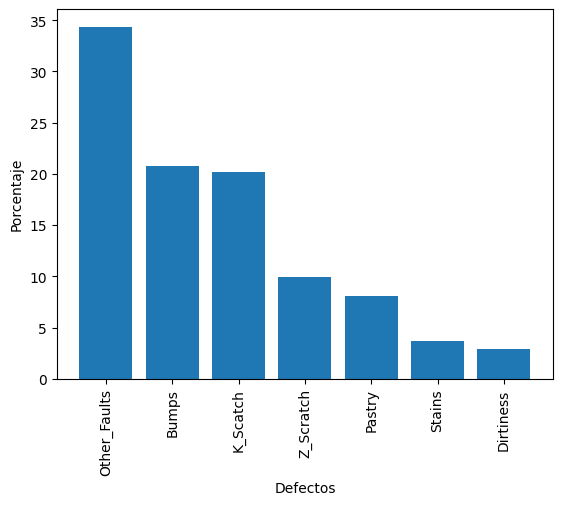

In [ ]:
aux= ((train['target'].value_counts()/train.shape[0])*100).rename_axis('class').reset_index()
plt.bar(aux['class'], aux['count'], )
plt.xticks(rotation=90)
plt.ylabel('Porcentaje')
plt.xlabel('Defectos')

# Limpieza de datos

En la etapa de limpieza de datos se pueden verificar :

*   Valores Nulos
*   Verificar formato de los datos
*   Duplicados
*   Valores atipicos
*   Eliminación de variables altamente correlacionadas






### Nulos

En  celdas anteriores como previo a la carga de los datos se exploro rapidamente los valores nulos ahora se procederá a revisar si existe al menos 1 en todo el DF.

In [ ]:
train.isnull().sum().sum()

0

Uno de los problemas tipicos al trabajar con datos es que los datos vengan en otro formato, es decir cuando uno ve el dato es un numero 1 pero el sistema lo ha leido como texto '1' causando complicaciones en los modelos.

### formato de las variables (tipo)

In [ ]:
train.dtypes

X_Minimum                  int64
X_Maximum                  int64
Y_Minimum                  int64
Y_Maximum                  int64
Pixels_Areas               int64
X_Perimeter                int64
Y_Perimeter                int64
Sum_of_Luminosity          int64
Minimum_of_Luminosity      int64
Maximum_of_Luminosity      int64
Length_of_Conveyer         int64
TypeOfSteel_A300           int64
TypeOfSteel_A400           int64
Steel_Plate_Thickness      int64
Edges_Index              float64
Empty_Index              float64
Square_Index             float64
Outside_X_Index          float64
Edges_X_Index            float64
Edges_Y_Index            float64
Outside_Global_Index     float64
LogOfAreas               float64
Log_X_Index              float64
Log_Y_Index              float64
Orientation_Index        float64
Luminosity_Index         float64
SigmoidOfAreas           float64
target                    object
dtype: object

### Duplicados

Validación de los duplicados en el DF

In [ ]:
aux=train.shape[0]
train.drop_duplicates(keep='first',inplace=True)
aux==train.shape[0]

True

Al parecer no existe duplicados en el DF, dado que la cantidad de columnas antes y despues de hacer la operación sigue siendo la misma

### Atipicos

Local Outlier Factor

In [ ]:
clf = LOF(contamination=0.1)
clf.fit(train.drop('target',axis=1))
atipicos = clf.predict(train.drop('target',axis=1))   ## etiquetas binarias (0: no atipicos, 1: atipicos)

atipicos=atipicos!=1
train=train.iloc[atipicos,:]
train.shape

(1322, 28)

### Alta Correlación

In [ ]:
correlacion = train.drop('target',axis=1).corr().unstack()
correla_ordena= correlacion.sort_values(kind="quicksort")

correla_ordena=correla_ordena[(correla_ordena > 0.90) &( correla_ordena<0.999)]
correla_ordena

LogOfAreas             Log_X_Index              0.901216
Log_X_Index            LogOfAreas               0.901216
Maximum_of_Luminosity  Luminosity_Index         0.913880
Luminosity_Index       Maximum_of_Luminosity    0.913880
Y_Perimeter            Pixels_Areas             0.954729
Pixels_Areas           Y_Perimeter              0.954729
Y_Perimeter            Sum_of_Luminosity        0.958623
Sum_of_Luminosity      Y_Perimeter              0.958623
X_Perimeter            Pixels_Areas             0.974513
Pixels_Areas           X_Perimeter              0.974513
Sum_of_Luminosity      X_Perimeter              0.976020
X_Perimeter            Sum_of_Luminosity        0.976020
Y_Perimeter            X_Perimeter              0.977837
X_Perimeter            Y_Perimeter              0.977837
X_Maximum              X_Minimum                0.991427
X_Minimum              X_Maximum                0.991427
Sum_of_Luminosity      Pixels_Areas             0.997331
Pixels_Areas           Sum_of_L

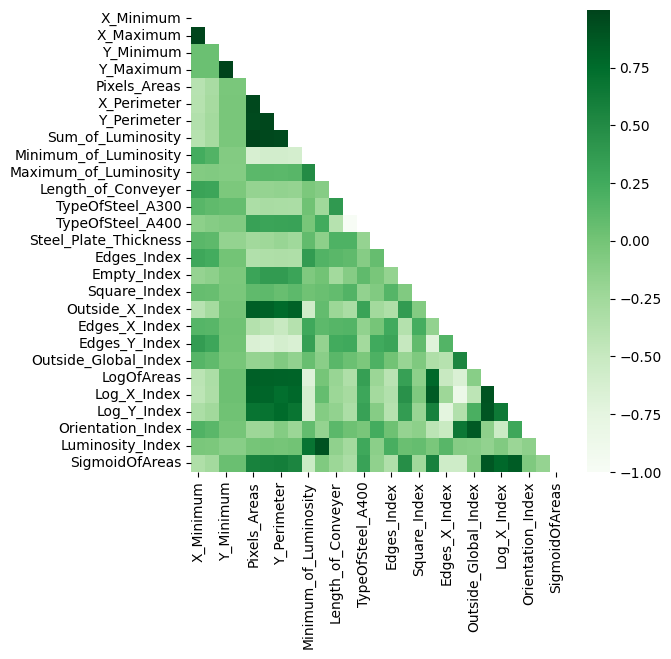

In [ ]:
grafica_correla(train.iloc[:,:-1])

In [ ]:
to_drop = refusion_dimension(train.drop('target',axis=1))
to_drop

['X_Minimum', 'Y_Minimum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter']

In [ ]:
train = train.drop(to_drop, axis=1)
train.shape

(1322, 23)

In [ ]:
X=train.drop('target', axis=1).values
y=train['target'].values

X.shape, y.shape

((1322, 22), (1322,))

# Transformación de datos

Para poder trabajar con algumos modelos de ML se quiere hacer un encoding para las variables, normalización/estadarización segun corresponda.

In [ ]:
label_encoder = preprocessing.LabelEncoder()
y=label_encoder.fit_transform(y)
y

array([3, 0, 0, ..., 6, 3, 2])

In [ ]:
X=preprocessing.scale(X)
X

array([[ 1.45284097, -0.90049171, -0.41018559, ...,  0.4166186 ,
        -0.46622624, -1.05573526],
       [-0.52164727, -0.6998491 , -0.39501208, ..., -0.92790963,
        -0.3318459 , -0.79539686],
       [ 0.90135292,  1.48458886, -0.39837167, ..., -1.23679615,
        -0.51319413, -0.57784136],
       ...,
       [-1.02281707, -0.61669185, -0.3917749 , ...,  0.68087434,
        -0.1120101 , -0.4358386 ],
       [-0.48944359, -0.34166807, -0.33594248, ...,  1.23450361,
         0.48552579,  0.77452253],
       [-0.90809145,  0.52517332,  1.67101813, ...,  0.14530497,
        -0.01089868,  1.39168837]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.2,random_state=SEED,stratify=y,shuffle=True)

# Catboost

Se usará una estrategia para que Catboost sea la proporción que tienen las clases

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [ ]:
train_dataset = Pool(X_train, y_train)

rscv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

model = CatBoostClassifier(
                           learning_rate=0.01
                           ,depth=6
                           ,n_estimators=100
                           ,loss_function='MultiClass'
                           ,train_dir= 'crossentropy'
                           ,early_stopping_rounds=200
                           ,bagging_temperature = 1
                           ,metric_period = 100
                           ,langevin=True
                           ,random_seed =SEED
                           ,class_weights =class_weights

                          )

model.fit(train_dataset,  verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Datos de Entrenamiento

In [ ]:
y_pred = model.predict(X_train)
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66       235
           1       0.39      1.00      0.56        28
           2       0.95      0.89      0.92       199
           3       0.77      0.37      0.50       362
           4       0.39      0.80      0.53        85
           5       0.76      0.91      0.83        43
           6       0.71      0.90      0.79       105

    accuracy                           0.67      1057
   macro avg       0.66      0.80      0.68      1057
weighted avg       0.72      0.67      0.66      1057



#### Datos de  test

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.71      0.62        59
           1       0.35      1.00      0.52         7
           2       1.00      0.82      0.90        50
           3       0.75      0.30      0.43        91
           4       0.36      0.62      0.46        21
           5       0.73      1.00      0.85        11
           6       0.60      0.92      0.73        26

    accuracy                           0.62       265
   macro avg       0.62      0.77      0.64       265
weighted avg       0.69      0.62      0.61       265



# HyperTunning  para Catboost

### Balanceo de clases
Se usara una libreria para hacer el balanceo de clases,
se probo una estrategia de decirle al algoritmo la proporción de las clases y se esperaba que este resultado fuera bueno. Dado que el supuesto es falso se procedio a hacer un balanceo de clases con estrategia más robustas.

In [ ]:
oversample = ADASYN(n_neighbors=6, random_state=SEED)
X_balance, y_balance = oversample.fit_resample(X_test, y_test)

clases_balance= pd.DataFrame.from_dict(Counter(y_balance), orient='index').reset_index()
clases_balance.columns=['defectos','porcentaje']
clases_balance['porcentaje']=round((clases_balance['porcentaje']/len(X_balance))*100,2)
clases_balance

,defectos,porcentaje
0,2,14.37
1,3,14.22
2,0,15.62
3,4,14.37
4,6,13.12
5,1,14.06
6,5,14.22


Cuando se entreno el modelo baseline usando CatBoost se uso una estrategia para decirle al algoritmo como estaban distribuidas las clases.
Para hacer el hypertunning no vamos a usar está estrategia sino que por el contrario usaremos una estrategia de balanceo de clases por lo cual es conveniente que el modelo base no tenga está opción impuesta.

In [ ]:
model = CatBoostClassifier(#iterations=500,
                           learning_rate=0.01
                           ,depth=6
                           ,n_estimators=100
                           ,loss_function='MultiClass'
                           ,train_dir= 'crossentropy'
                           ,early_stopping_rounds=200
                           ,metric_period = 100
                           ,random_seed =SEED
                           #,task_type="GPU"
                          )

model.fit(train_dataset,  verbose=False, plot=True)

parameters = {'depth'         : [5,6,7,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'n_estimators'    : [75,100,120]
                 }

Grid_CBC_balance = GridSearchCV(estimator=model
                                ,param_grid = parameters
                                ,cv = rscv
                                ,scoring="accuracy"
                                ,n_jobs=-1)

Grid_CBC_balance.fit(X_balance, y_balance)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.8742504	total: 48.8ms	remaining: 5.8s
100:	learn: 0.4070332	total: 6.79s	remaining: 1.28s
119:	learn: 0.3480472	total: 7.59s	remaining: 0us


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=111, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x799325e5a6e0>,
             n_jobs=-1,
             param_grid={'depth': [5, 6, 7, 9, 10],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04],
                         'n_estimators': [75, 100, 120]},
             scoring='accuracy')

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

#### Datos de Test

In [ ]:
Grid_CBC_balance.best_params_,Grid_CBC_balance.best_estimator_

({'depth': 10, 'learning_rate': 0.04, 'n_estimators': 120},
 <catboost.core.CatBoostClassifier at 0x7f2af28cd650>)

In [ ]:
y_pred = Grid_CBC_balance.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        88
           1       0.85      1.00      0.92        11
           2       1.00      1.00      1.00        75
           3       1.00      0.94      0.97       136
           4       0.94      1.00      0.97        32
           5       1.00      1.00      1.00        16
           6       0.97      1.00      0.99        39

    accuracy                           0.98       397
   macro avg       0.96      0.99      0.97       397
weighted avg       0.98      0.98      0.98       397



# Validación del modelo

Ahora que se tiene el modelo entrenado, se usarán el otro conjunto de datos suministrados para validarlo.

In [ ]:
test=pd.read_csv(link_lectura+name_file_test, sep='\t',index_col=0)
print("La dimension del DataFrame de test es {}".format(test.shape))

NameError: ignored

In [ ]:
test

NameError: ignored

Se coloca un procedimiento para garantizar que el nombre de las columnas en los dos archivos entregados por la empresa sean similares, excluyendo de DF de train la variable objetivo.

In [ ]:
test= test[etiquetas]
test

In [ ]:
XX_test=test.values
XX_test.shape

In [ ]:
XX_test=preprocessing.scale(XX_test)

In [ ]:
yy_pred = Grid_CBC_balance.best_estimator_.predict(XX_test)
defectos= label_encoder.inverse_transform(yy_pred)
defectos

In [ ]:
test['target']=defectos
test

In [ ]:
test.to_csv(link_lectura+name_user+"/"+name_file_exist)